# Binary Classification project: 'sad' & 'happy' categories

### environment creation workflow
-m venv imageclassification  in CMD
!pip install ipykernel

## 1. Getting started

### 1.1 Install libraries 

In [18]:
import sys
print(sys.version)

3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]


In [19]:
import cv2 # computer vision module
import imghdr  # checks file extensions
import os
import numpy as np
import matplotlib.pyplot as plt # we visualize our images with plt
import tensorflow as tf
# !pip list  # check our libraries are actually installed

#### config specific environment and gpu usage

In [20]:
# Avoid out of memory (OOM) erros by setting GPU Mermory Consumption Growth

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_momory_growth(gpu,True)

#### check: 
print(gpus)
len(gpus)

### 1.2. Remove unuseful images

In [21]:
data_dir='data'
image_extensions = ['jpeg','jpg','png','bmp']

In [22]:
os.listdir(data_dir) 

['happy', 'sad']

In [23]:
# get rid of unuseful images in data folder since we downloaded a bunch of happy & sad people images from the internet 
# and we might get a few files that we need to remove
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)): # loop through our class folder
        image_path = os.path.join(data_dir, image_class, image) # loop through every single image
        try:
            img = cv2.imread(image_path) # load images as np array
            extension_checked = imghdr.what(image_path) #  identify the type of image file that is passed to it. 
            if extension_checked not in image_extensions:
                print(f"Image not in extensions list {image_extensions}")
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with image {image_path}')
            #os.remove(image_path)

(880, 1400, 3)


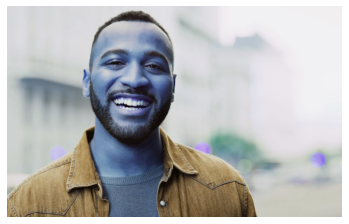

In [24]:
# let's check how it reads a random image
img=cv2.imread(r'data\happy\05-12-21-happy-people.jpg')
print(img.shape)
plt.axis('Off')
plt.imshow(img);

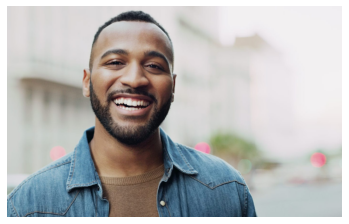

In [25]:
# open cv2 uses 3 channels but readin in BGR not in RGB. let's change it
plt.axis('Off')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB));

### 1.3. Load Data

##### tf.keras.utils.image_dataset_from_directory()
##### in a nutshell, it resizes images to (256,256), shuffles them, creates a validation split 

In [26]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 1992 files belonging to 2 classes.


In [27]:
# the keras generator created above does not allow me to grab lets say the first element in that variable sinces it is not a pd.DataFrame
# we can pass it as a numpy iterator and the get consecutive batches with .next()
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
len(batch) # batch has 2 parts: 1: images np arrays, 2:labels

2

In [28]:
batch[0].shape  # 32 corresponds to default batch size of the keras.utils.image_dataset_from_directory()

(32, 256, 256, 3)

In [29]:
batch[1]

array([0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0])

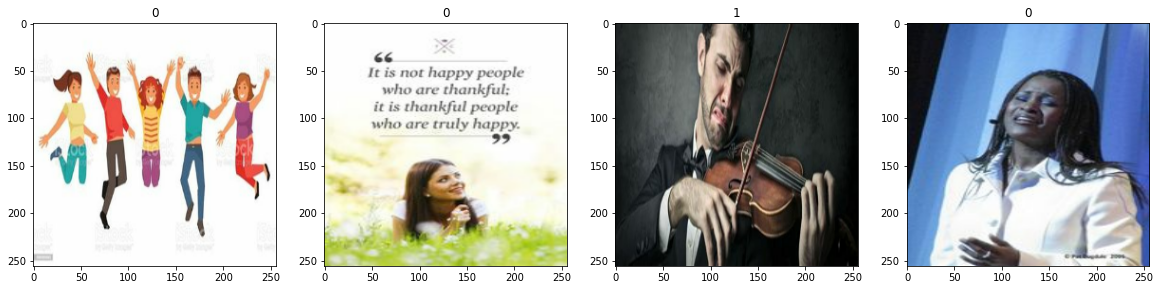

In [30]:
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])    

In [31]:
# get a new batch of data from data pipeline
batch = data_iterator.next()
batch[1] #labels will change if we compare them to previous batch some lines above

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0])

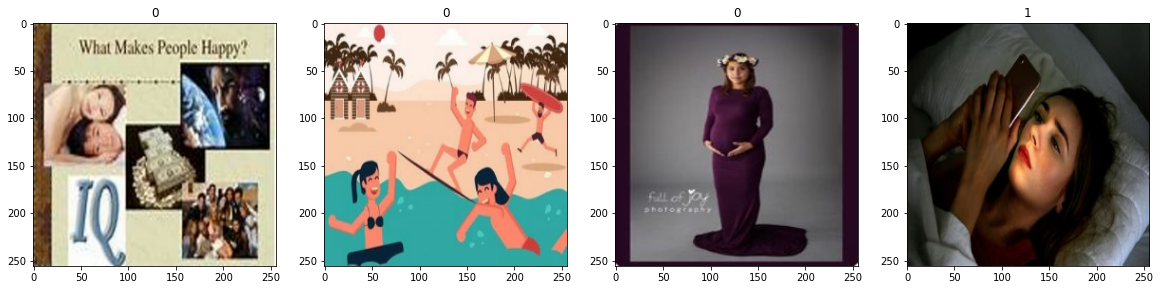

In [32]:
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 2. Preprocess Data

### 2.1 Scale data

In [33]:
batch[0].shape # so batch_size:32, 256 x 256 images by 3 channels

(32, 256, 256, 3)

In [34]:
batch[0].min(), batch[0].max()

(0.0, 255.0)

##### Normalize feature values
By mapping each feature value from its current representation (an integer between 0 and 255) to a floating-point value between 0 and 1.0

In [35]:
# if our values are even smaller, our model will be faster. So lets convert them into [0,1] values
scaled_batch = batch[0] / 255   
scaled_batch.min(), scaled_batch.max()

(0.0, 1.0)

In [36]:
# let's do it in a more effective way using map to apply lambda function in the WHOLE pipeline
# x is our independent variable (our images) and y is our taget / labels
scaled_data = data.map(lambda x, y: (x / 255, y))
scaled_iterator = scaled_data.as_numpy_iterator()
batch = scaled_iterator.next()

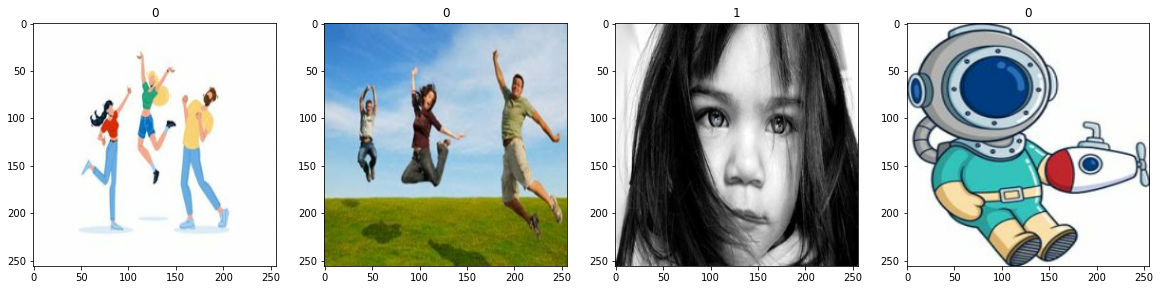

In [37]:
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [38]:
# check we're doing it for any of our batches
scaled_data.as_numpy_iterator().next()[0].min(), scaled_data.as_numpy_iterator().next()[0].max()

(0.0, 1.0)

### 2.2 Split Data

In [39]:
len(scaled_data)

63

In [40]:
train_size = int(len(scaled_data)*.7)
val_size = int(len(scaled_data)*.2)
test_size = int(len(scaled_data)*.1)+1
train_size+ val_size+test_size

63

In [41]:
train_data = scaled_data.take(train_size) # we'll allocate this data to our train data partition
val_data = scaled_data.skip(train_size).take(val_size)# skip the one allocated to train
test_data =scaled_data.skip(train_size+val_size).take(test_size) # what's leftover 

## 3. Model

### 3.1 Build it

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [43]:
model = Sequential()

In [44]:
# add a convolution block with 16 filters (aka 'convolutions') | every filter has a 3x3 size pixel 
# there'is a stride of 1 of the filter (i.e, each time the filter moves it does it by one pixel)
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D()) # takes the maximum values of the featured map postReLu - so condenses info

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# condense layers into a single value (multiplying size by channels)
model.add(Flatten())

# fully connected layers (aka 'dense')
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation='sigmoid')) # 1 i.e. just one output layer

In [45]:
# compile model using 'adam' optimizer, a binary loss and set our metric
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [46]:
model.summary() 
# note: in summary of dense_1 (shown below) we see 257 params, that's because we have our 256 inputs + our bias, thus 257 total

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

### 3.2 Train it

In [47]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir) #great for saving checkpoints and making logs

In [48]:
hist = model.fit(train_data, epochs = 20, validation_data = val_data, callbacks = [tensorboard_callback])

Epoch 1/20
44/44 [==============================] - 31s 682ms/step - loss: 0.7521 - accuracy: 0.5661 - val_loss: 0.6310 - val_accuracy: 0.6432
Epoch 2/20
44/44 [==============================] - 31s 704ms/step - loss: 0.6167 - accuracy: 0.6726 - val_loss: 0.5723 - val_accuracy: 0.7292
Epoch 3/20
44/44 [==============================] - 33s 736ms/step - loss: 0.5897 - accuracy: 0.6996 - val_loss: 0.5221 - val_accuracy: 0.7604
Epoch 4/20
44/44 [==============================] - 32s 727ms/step - loss: 0.5357 - accuracy: 0.7287 - val_loss: 0.4999 - val_accuracy: 0.7786
Epoch 5/20
44/44 [==============================] - 33s 745ms/step - loss: 0.5168 - accuracy: 0.7550 - val_loss: 0.5191 - val_accuracy: 0.7500
Epoch 6/20
44/44 [==============================] - 30s 685ms/step - loss: 0.4453 - accuracy: 0.7912 - val_loss: 0.4941 - val_accuracy: 0.7526
Epoch 7/20
44/44 [==============================] - 30s 677ms/step - loss: 0.3824 - accuracy: 0.8416 - val_loss: 0.5449 - val_accuracy: 0.7448

In [49]:
hist.history

{'loss': [0.7521178722381592,
  0.6166735291481018,
  0.589733362197876,
  0.5356765389442444,
  0.51682448387146,
  0.44526776671409607,
  0.38235875964164734,
  0.31343957781791687,
  0.244419664144516,
  0.15268748998641968,
  0.16387219727039337,
  0.1519634872674942,
  0.07499929517507553,
  0.07151187211275101,
  0.05894167721271515,
  0.08360124379396439,
  0.0527011901140213,
  0.02882103994488716,
  0.034519705921411514,
  0.02822413295507431],
 'accuracy': [0.5660511255264282,
  0.6725852489471436,
  0.6995738744735718,
  0.7286931872367859,
  0.7549715638160706,
  0.7911931872367859,
  0.8416193127632141,
  0.8686079382896423,
  0.9055397510528564,
  0.9438920617103577,
  0.9353693127632141,
  0.9495738744735718,
  0.9751420617103577,
  0.9829545617103577,
  0.9829545617103577,
  0.9786931872367859,
  0.984375,
  0.9936079382896423,
  0.9964488744735718,
  0.9957386255264282],
 'val_loss': [0.6309526562690735,
  0.5722789168357849,
  0.5220806002616882,
  0.4999256432056427,

### 3.3 Plot performance

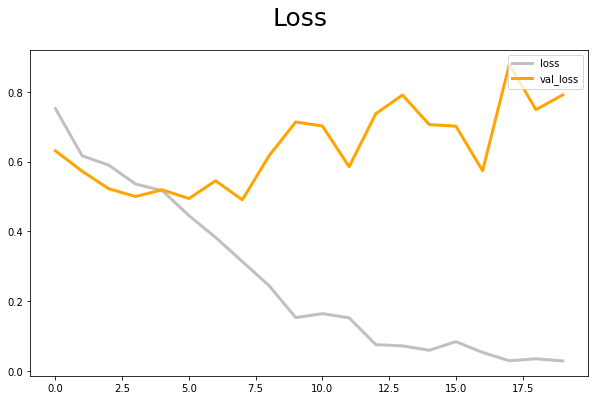

In [50]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color = 'silver', label='loss', linewidth=3)
plt.plot(hist.history['val_loss'], color = 'orange', label='val_loss', linewidth=3)
fig.suptitle('Loss', fontsize=25)
plt.legend(loc='upper right')
plt.show()

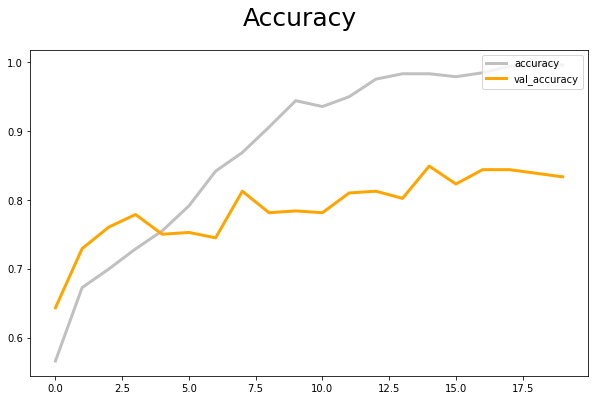

In [51]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color = 'silver', label='accuracy', linewidth=3)
plt.plot(hist.history['val_accuracy'], color = 'orange', label='val_accuracy', linewidth=3)
fig.suptitle('Accuracy', fontsize=25)
plt.legend(loc='upper right')
plt.show()

## 4. Performance evaluation

### 4.1 Evaluate our model

In [52]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [53]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [54]:
len(test_data)

7

In [55]:
for batch in test_data.as_numpy_iterator():
    X, y=batch # we had our np.arrays in batch[0] and our labels / targets in batch[1]
    y_pred = model.predict(X)
    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)    

1/1 [==============================] - 0s 170ms/step


In [56]:
print(f'Precision: {precision.result()}. Recall: {recall.result()}, Accuracy: {accuracy.result()}')

Precision: 0.8064516186714172. Recall: 0.5813953280448914, Accuracy: 0.7599999904632568


## 4.2 Test our model on random images

In [68]:
base = os.getcwd()
test_dir = base+'\\images_not _data'
# os.listdir(test_dir)

##### test 1

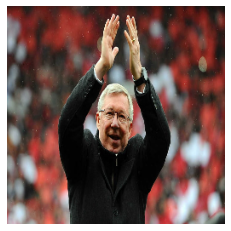

In [58]:
# Load image and change it from BGR to RGB format
image = cv2.imread(test_dir + '\\SAF.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize the image
image = cv2.resize(image, (256, 256))

# Show the image
plt.axis('Off')
plt.imshow(image);

In [59]:
print(image.shape)

(256, 256, 3)


In [60]:
# our model will expect a list of images, not just one. Thus, we should increase our number of dimension
np.expand_dims(image,0).shape

(1, 256, 256, 3)

In [61]:
test_pred = model.predict(np.expand_dims(image/255,0))
print(test_pred)

if test_pred > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

1/1 [==============================] - 0s 31ms/step
[[0.01120497]]
Predicted class is Happy


##### test 2

1/1 [==============================] - 0s 38ms/step
Predicted class is Sad


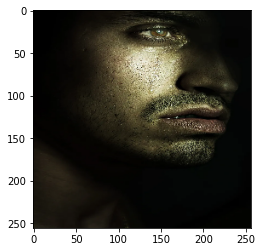

In [71]:
image2 = cv2.imread(test_dir + '\\sadtest.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Resize the image
image2 = cv2.resize(image2, (256, 256))

# Show the image
plt.imshow(image2);

test_pred = model.predict(np.expand_dims(image2/255,0))
if test_pred > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

## Save the model

In [72]:
from tensorflow.keras.models import load_model

In [73]:
model.save(os.path.join('models','HappySadBinaryModel.h5'))

In [74]:
os.path.join('models','HappySadBinaryModel.h5')

'models\\HappySadBinaryModel.h5'

In [75]:
new_model = load_model(os.path.join('models','HappySadBinaryModel.h5'))

1/1 [==============================] - 0s 29ms/step
Predicted class is Happy


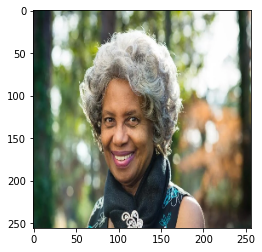

In [78]:
image4 = cv2.imread(test_dir + '\\happytest1.jpg')
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)
# Resize the image
image4 = cv2.resize(image4, (256, 256))
# Show the image
plt.imshow(image4);

new_model.predict(np.expand_dims(image4/255, 0))

test_pred = model.predict(np.expand_dims(image4/255,0))

if test_pred > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')     